# Latents MODIS R2019 valid

In [1]:
%matplotlib inline

from importlib import reload
import os
import numpy as np
from pkg_resources import resource_filename
import datetime

import pandas

import h5py
import seaborn as sns
import pandas as pd

import umap
from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.ssl.my_util import modis_loader, set_model
from ulmo.ssl.my_util import Params, option_preprocess
from ulmo.ssl import latents_extraction

import torch

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

In [69]:
sns.set_theme()
#sns.set_style('whitegrid')
sns.set_context('notebook')
pal, cm = plotting.load_palette()

# Load

## Images

In [5]:
modis_R2019_data = '/data/Projects/Oceanography/AI/OOD/SST/MODIS_L2/PreProc/MODIS_R2019_2010_95clear_128x128_preproc_std.h5'
with h5py.File(modis_R2019_data, 'r') as f:
    modis_R2019 = f['valid'][:]
    #modis_R2019_train = f['train'][:]
modis_R2019.shape

(542845, 1, 64, 64)

## Latents

## Valid

In [21]:
# Down load the file
modis_R2019_latents = 's3://modis-l2/SSL_MODIS_R2019_2010_latents_valid/modis_R2019_2010_latents_last.h5'
ulmo_io.download_file_from_s3(os.path.basename(modis_R2019_latents), modis_R2019_latents)

Done!


In [22]:
# Renamed to modis_R2019_2010_latents_last_valid.h5

In [24]:
with h5py.File('modis_R2019_2010_latents_last_valid.h5', 'r') as f:
    latents_R2019_valid = f['modis_latents'][:]
latents_R2019_valid.shape

(542845, 256)

## Train -- for UMAP training

In [7]:
with h5py.File('modis_R2019_2010_latents_last.h5', 'r') as f:
    latents_R2019_train = f['modis_latents'][:]
latents_R2019_train.shape

(135712, 256)

## Table

In [2]:
modis_tbl = ulmo_io.load_main_table('s3://modis-l2/Tables/MODIS_L2_std.parquet')

Read main table: s3://modis-l2/Tables/MODIS_L2_std.parquet


In [3]:
modis_tbl.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx
0,13.980967,62.675774,517,2003-03-10 21:25:00,520.178711,304,0.000000,26.199476,25.250000,26.885000,26.474998,25.814999,AQUA_MODIS.20030310T212506.L2.SST.nc,1047103981024267577,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,0
1,13.043748,-102.751816,706,2003-12-12 08:30:00,432.766724,1696,0.049805,28.924648,27.789999,29.654999,29.154999,28.695000,AQUA_MODIS.20031212T083006.L2.SST.nc,107110304377724818,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,1
2,-18.086618,40.844833,581,2003-09-24 22:35:00,764.413086,656,0.006104,25.551611,24.775000,26.154999,25.750000,25.344999,AQUA_MODIS.20030924T223506.L2.SST.nc,106471913422084483,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,2
3,39.071575,18.569141,1028,2003-05-01 01:05:00,371.310120,898,0.049988,16.414951,15.160000,17.205000,16.725000,16.080000,AQUA_MODIS.20030501T010506.L2.SST.nc,1051129071619856914,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,3
4,17.901926,90.155480,997,2003-12-05 19:55:00,-214.759277,1520,0.035461,26.744499,24.975000,28.724998,27.824999,25.830000,AQUA_MODIS.20031205T195506.L2.SST.nc,1070107901927015548,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,4


In [4]:
valid = modis_tbl.pp_type == 0
#year = (modis_tbl.datetime >= datetime.datetime(2010,1,1)) & (modis_tbl.datetime < datetime.datetime(2011,1,1))
y2010 = modis_tbl.pp_file == 's3://modis-l2/PreProc/MODIS_R2019_2010_95clear_128x128_preproc_std.h5'
valid_tbl = modis_tbl[valid & y2010]
valid_tbl.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx
5270671,34.295185,24.922207,581,2010-07-08 00:15:00,116.808716,1072,0.000000,25.010387,23.965000,26.154999,25.580000,24.480000,AQUA_MODIS.20100708T001508.L2.SST.nc,1278124295220492221,s3://modis-l2/PreProc/MODIS_R2019_2010_95clear...,standard,128,0,0
5270672,-46.509500,-57.851720,485,2010-07-18 18:05:00,153.916016,1776,0.000183,6.802653,4.325000,8.050000,7.530000,5.995000,AQUA_MODIS.20100718T180507.L2.SST.nc,127943490512214828,s3://modis-l2/PreProc/MODIS_R2019_2010_95clear...,standard,128,0,1
5270673,-37.433930,124.080086,470,2010-01-08 16:45:00,134.188660,1759,0.048767,18.039135,16.219999,19.379999,18.705000,16.914412,AQUA_MODIS.20100108T164500.L2.SST.nc,126252566130408009,s3://modis-l2/PreProc/MODIS_R2019_2010_95clear...,standard,128,0,2
5270674,30.949060,-80.014700,677,2010-11-09 07:15:00,-92.706116,1232,0.000183,25.282747,21.125000,27.615000,27.029999,22.885000,AQUA_MODIS.20101109T071508.L2.SST.nc,128912094919998530,s3://modis-l2/PreProc/MODIS_R2019_2010_95clear...,standard,128,0,3
5270675,-26.466375,35.464664,837,2010-09-23 23:05:00,110.181030,848,0.000122,22.567062,21.330000,24.730000,23.670000,22.035000,AQUA_MODIS.20100923T230507.L2.SST.nc,128563533621546466,s3://modis-l2/PreProc/MODIS_R2019_2010_95clear...,standard,128,0,4


In [6]:
len(valid_tbl), modis_R2019.shape[0]

(542845, 542845)

In [7]:
# Write (for web portal)
valid_tbl.to_parquet('ulmo_2010_valid_v1.parquet')

### Check $\Delta T$ just to be safe..

In [28]:
valid_img = modis_R2019[3,0,...]

In [29]:
np.percentile(valid_img, [10, 90])

array([-2.40774727,  1.72600174])

In [30]:
27.03-22.885, 1.726+2.4077

(4.145, 4.1337)

----

# UMAP

## Fit

In [17]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_R2019_train)

CPU times: user 15min 57s, sys: 1min 53s, total: 17min 51s
Wall time: 1min 51s


## Plot

In [18]:
num_samples = latents_R2019_train.shape[0]
point_size = 20.0 / np.sqrt(num_samples)
dpi = 100

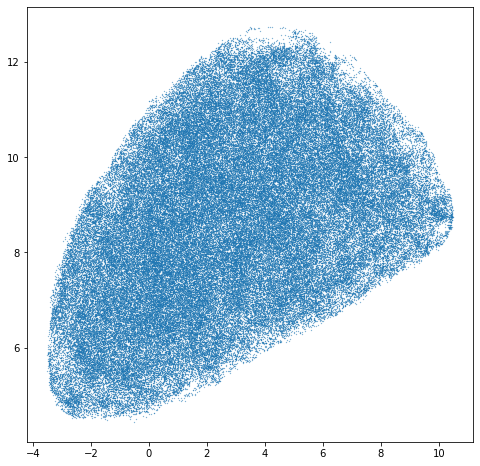

In [19]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(latents_mapping.embedding_[:, 0], 
            latents_mapping.embedding_[:, 1], s=point_size)

# Apply to valid

In [25]:
valid_embedding = latents_mapping.transform(latents_R2019_valid)

In [26]:
valid_embedding.shape

(542845, 2)

### Plot

In [35]:
num_samplesv = latents_R2019_valid.shape[0]
point_sizev = 1.0 / np.sqrt(num_samplesv)

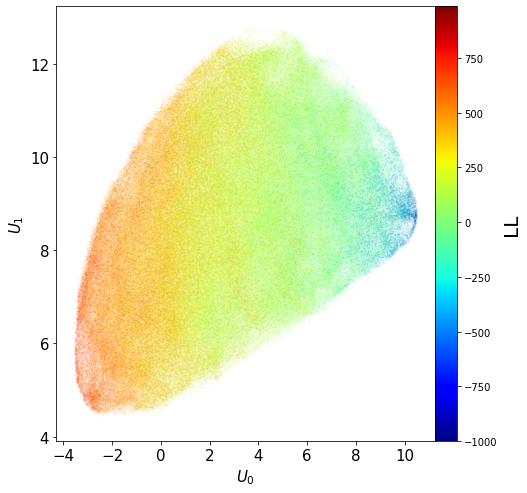

In [53]:
width, height = 800, 800
plt.figure(figsize=(width//dpi, height//dpi))
ax = plt.gca()
img = ax.scatter(valid_embedding[:, 0], 
            valid_embedding[:, 1], s=point_sizev,
           c=valid_tbl.LL, cmap='jet', vmin=-1000)
#ax.scatter(valid_embedding[lowLL, 0], 
#            valid_embedding[lowLL, 1], s=point_sizev*30,
#           c='k')
cb = plt.colorbar(img, pad=0.)
cb.set_label('LL', fontsize=20.)
#
ax.set_xlabel(r'$U_0$')
ax.set_ylabel(r'$U_1$')
plotting.set_fontsize(ax, 15.)
#
plt.savefig('UMAP_LL.png', dpi=200)

### Lower LL

In [41]:
lowLL = valid_tbl.LL < -1000.

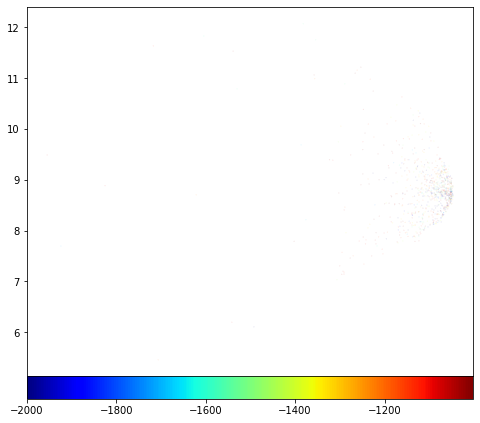

In [42]:
plt.figure(figsize=(width//dpi, height//dpi))
img = plt.scatter(valid_embedding[lowLL, 0], 
            valid_embedding[lowLL, 1], s=point_sizev,
           c=valid_tbl[lowLL].LL, cmap='jet', vmin=-2000)
cb = plt.colorbar(img, orientation='horizontal', pad=0.)

----

# Plot some cutouts!

In [145]:
U0s = [-3.8, -2, 2, 3, 8, 8, 10, 10]
U1s = [5, 9, 6, 11.5, 7.8, 10.7, 8.2, 9.2]
chosen = [2, 11, 10, 11, 7, 7, 13, 0]

In [113]:
def grab_em(idx):
    U0, U1 = U0s[idx], U1s[idx]
    print('Using: {}, {}'.format(U0,U1))
    dist = np.sqrt((valid_embedding[:, 0]-U0)**2 + (valid_embedding[:,1]-U1)**2)
    srt_dist = np.argsort(dist)
    top20 = srt_dist[0:20]
    return top20, srt_dist, dist

In [114]:
def show_gallery(idx):
    top20, srt_dist, dist = grab_em(idx)
    plt.figure(figsize=(28, 16))
    for i in range(20):
        plt.subplot(4, 5, i+1)
        sns.heatmap(modis_R2019[top20[i],0,...], xticklabels=[], yticklabels=[], cmap=cm, 
                    cbar=True)
        plt.title(f'the distance to the target cutout: {dist[srt_dist][i]:.2f}')

In [163]:
def show_gallery2(idx):
    top20, srt_dist, dist = grab_em(idx)
    plt.figure(figsize=(20, 16))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        sns.heatmap(modis_R2019[top20[i],0,...], xticklabels=[], yticklabels=[], cmap=cm, 
                    cbar=True)
        #lt.title(f'the distance to the target cutout: {dist[srt_dist][i]:.2f}')
    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
    # Save
    outfile = 'gallery_{}.png'.format(idx)
    plt.savefig(outfile, dpi=400)
    print("Wrote: {}".format(outfile))

In [164]:
def plt_cutout(idx):
    top20, _, _ = grab_em(idx)
    plt.figure(figsize=(12,8))
    ax = plt.gca()
    img = ax.imshow(modis_R2019[top20[chosen[idx]],0,...],  cmap=cm)
    plt.xticks([])
    plt.yticks([])
    # color bar
    cb = plt.colorbar(img, pad=0.02, fraction=0.04)
    cb.set_label('SSTa', fontsize=20.)
    cb.ax.tick_params(labelsize=15)
    # Save
    outfile = 'cutout_{}.png'.format(idx)
    plt.savefig(outfile, dpi=400)
    print("Wrote: {}".format(outfile))

Using: 8, 7.8


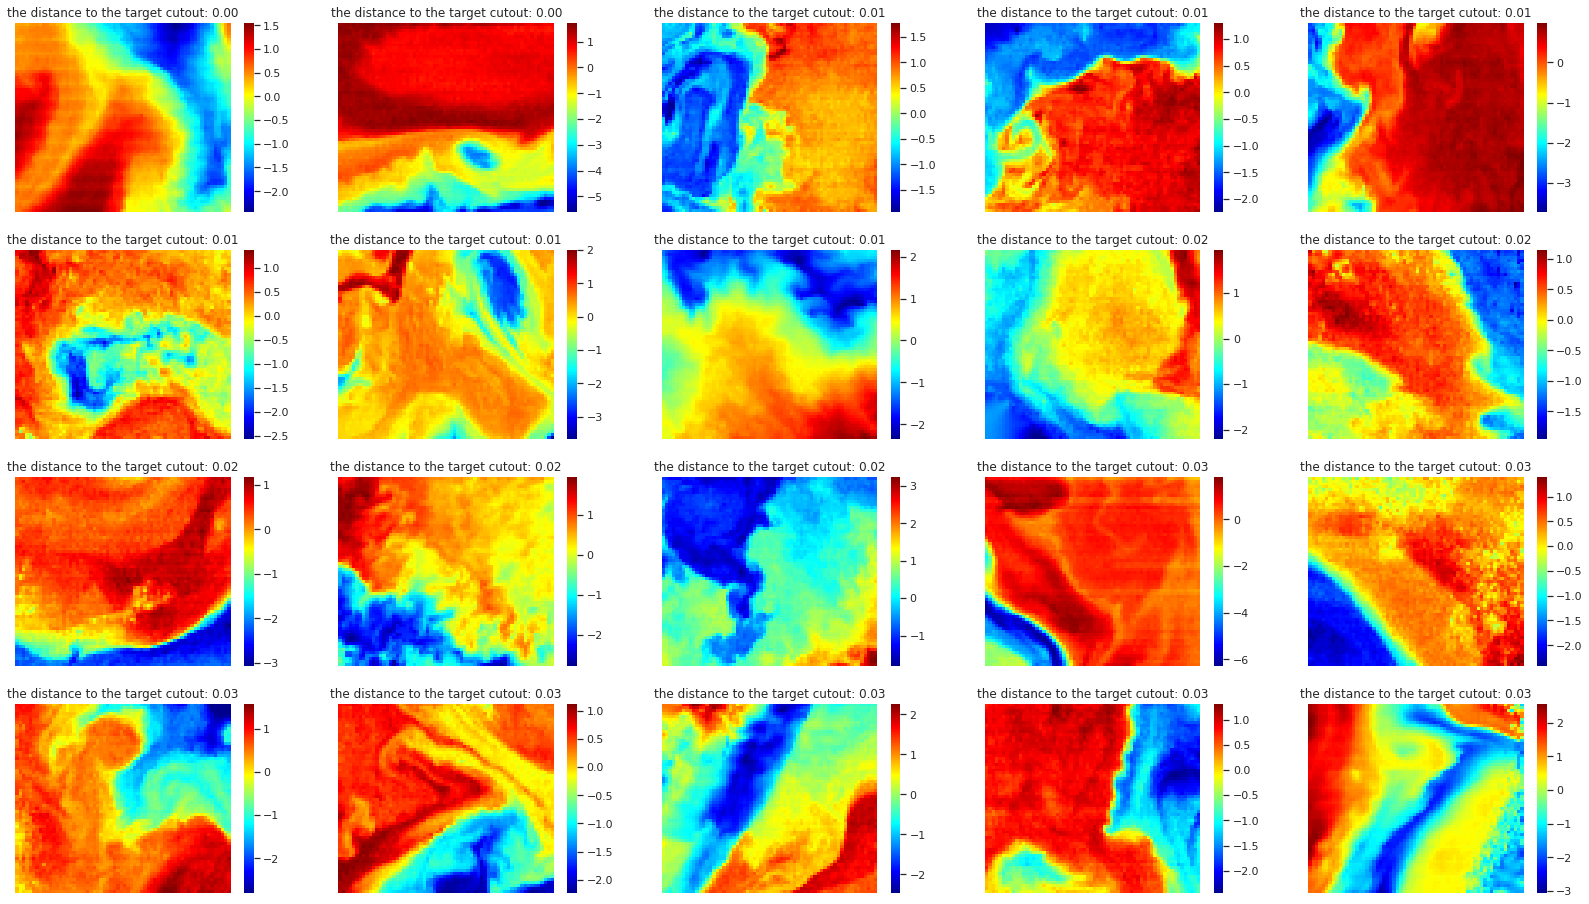

In [166]:
show_gallery(4)

Using: 8, 7.8
Wrote: gallery_4.png


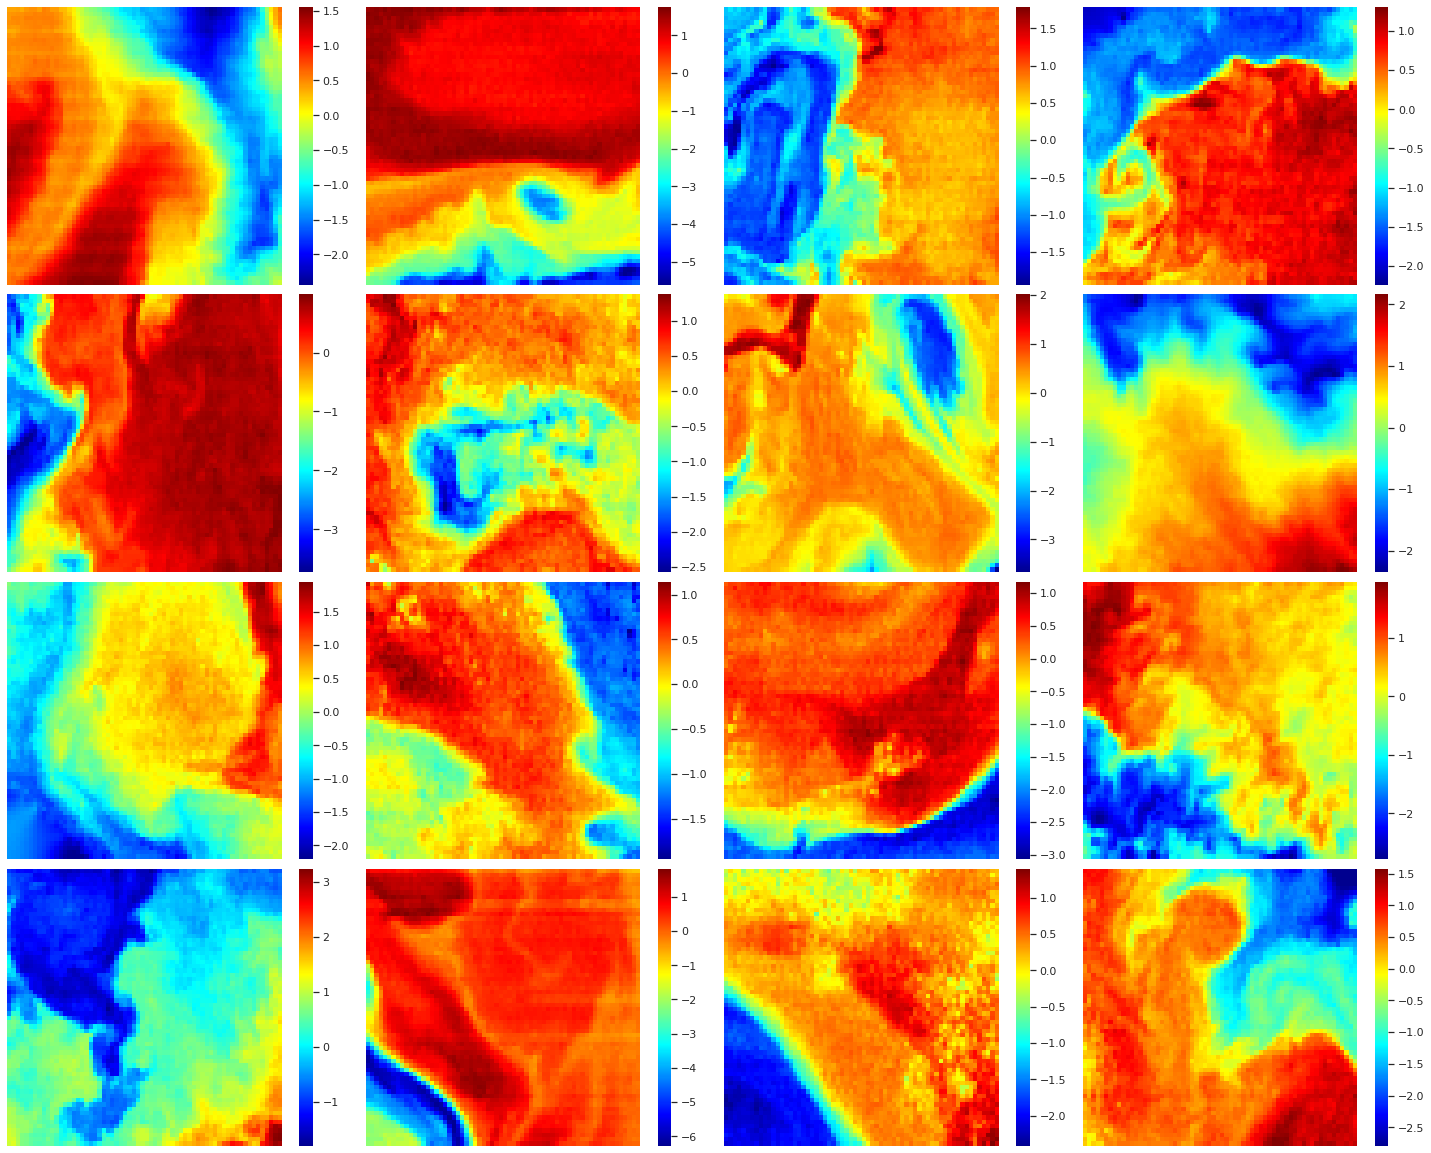

In [165]:
show_gallery2(4)

Using: 10, 9.2
Wrote: cutout_7.png


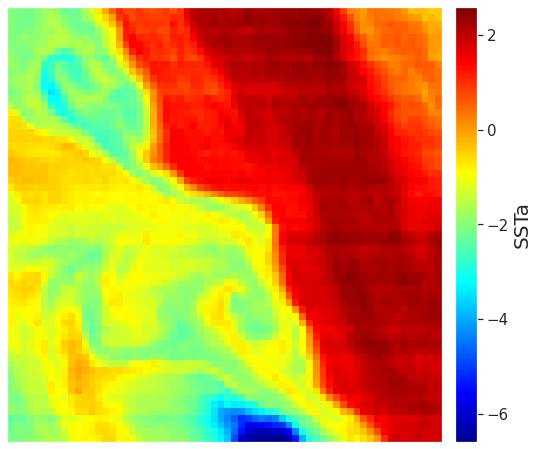

In [146]:
plt_cutout(7)

## Another high LL but far away

In [81]:
U0, U1 = 
dist = np.sqrt((valid_embedding[:, 0]-U0)**2 + (valid_embedding[:,1]-U1)**2)
srt_dist = np.argsort(dist)
top20 = srt_dist[0:20]

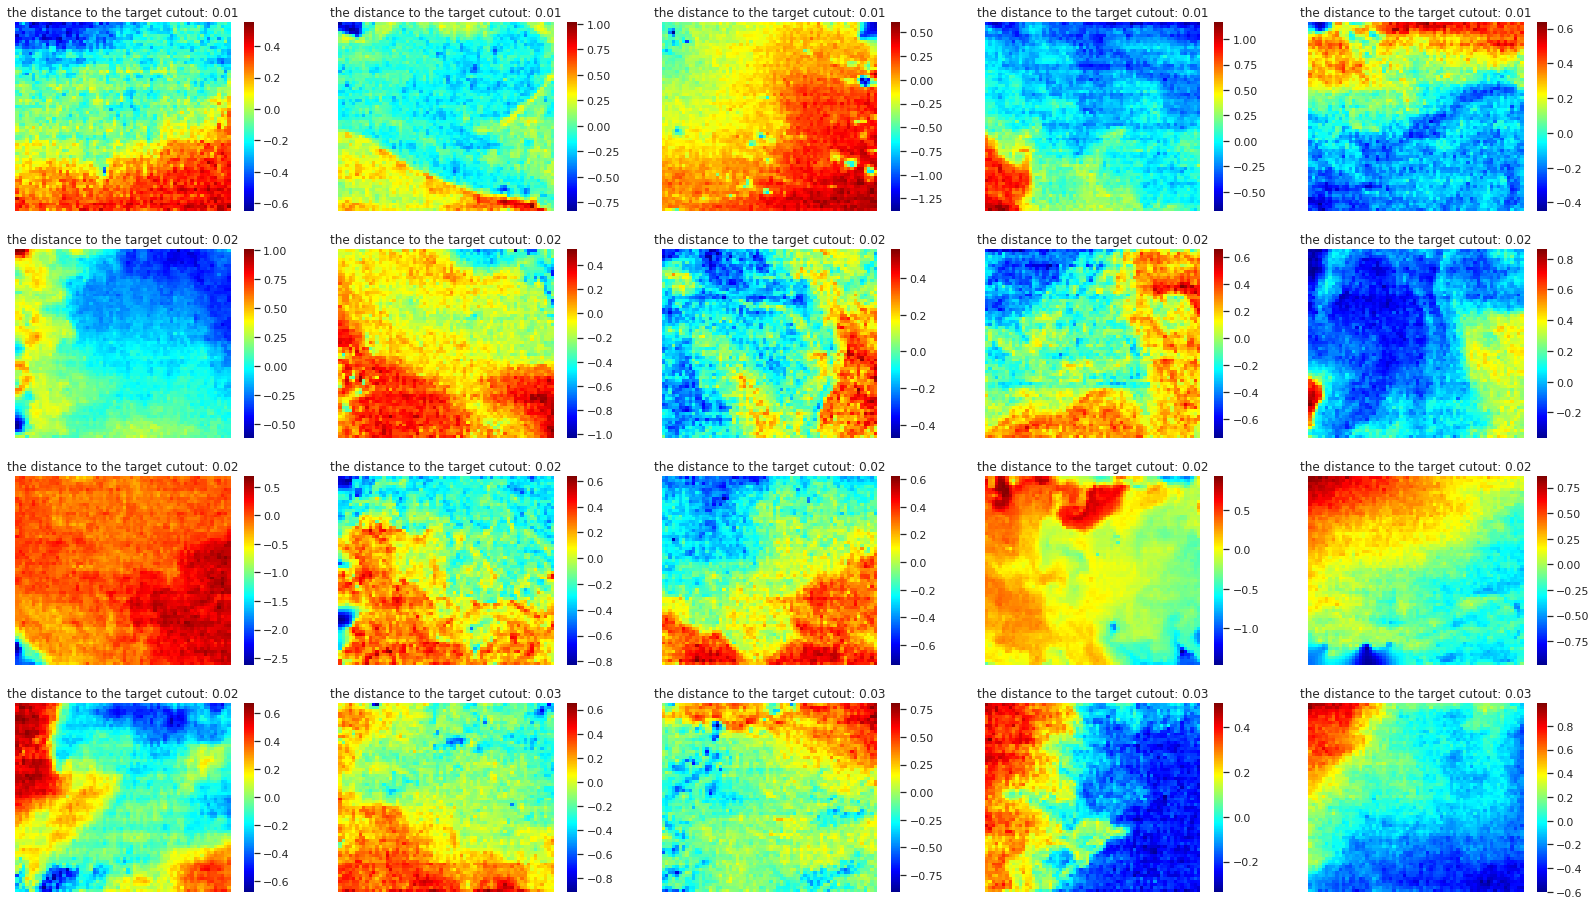

In [82]:
plt.figure(figsize=(28, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.heatmap(modis_R2019[top20[i],0,...], xticklabels=[], yticklabels=[], cmap=cm, 
                cbar=True)
    plt.title(f'the distance to the target cutout: {dist[srt_dist][i]:.2f}')